In [3]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD

In [4]:
from keras.metrics import MeanSquaredError 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adagrad
from keras.optimizers import Adam
from keras.optimizers import Nadam

In [6]:
all_data1=pd.read_csv('삼성전자주가(20220406-20240405).csv')
print('Number of rows and columns:', all_data1.shape)
all_data1["Datetime"] = pd.to_datetime(all_data1["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
all_data1['Datetime'] = pd.to_datetime(all_data1['Datetime'])
all_data1.set_index('Datetime', inplace=True)
all_data1.head(5) # volume = 거래량

Number of rows and columns: (2960, 7)


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,68700.0,1846582
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,68600.0,901392
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,68600.0,2053045
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,68600.0,924688


In [40]:
# scale the data 
sc = MinMaxScaler(feature_range=(0,1)) #Normalizer() #StandardScaler() RobustScaler()
data= sc.fit_transform(all_data1.iloc[:,3:4].values)

# 훈련 데이터 비율
TRAIN_SPLIT = 0.8

# 시퀀스 길이 (7일)
SEQ_LEN = 7

# 전체 데이터 길이
total_data_len = len(data)

# 훈련 데이터 길이
train_data_len = int(total_data_len * TRAIN_SPLIT)

# Train, Validation, Test 데이터 분할
train_data = data[:train_data_len]
val_data = data[train_data_len:train_data_len + int(0.1 * (total_data_len - train_data_len))]
test_data = data[train_data_len + int(0.1 * (total_data_len - train_data_len)):]

# 데이터셋 생성
def create_dataset(data, seq_len):
    x_data, y_data = [], []
    for i in range(len(data) - seq_len):
        x_data.append(data[i:i + seq_len])
        y_data.append(data[i + seq_len])
    return np.array(x_data), np.array(y_data)

# Train, Validation, Test 데이터셋 생성
x_train, y_train = create_dataset(train_data, SEQ_LEN)
x_val, y_val = create_dataset(val_data, SEQ_LEN)
x_test, y_test = create_dataset(test_data, SEQ_LEN)

In [47]:
def LSTM_model(x_train, y_train, x_test, sc):
    
    # The LSTM architecture
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (x_train.shape[1],1), 
                           activation = 'tanh'))
    LSTM_model.add(LSTM(units=128, input_shape=(x_train.shape[1], 1)))
    LSTM_model.add(Dropout(0.2))
    LSTM_model.add(Dense(units=2))

    # relu
    #LSTM_model.add(LSTM(20, activation='relu', input_shape=(3,1)))
    #LSTM_model.add(Dense(5))
    #LSTM_model.add(Dense(1))
    #LSTM_model.compile(optimizer='adam',loss='mse')

    
    # Compiling 
    LSTM_model.compile( optimizer = Nadam(learning_rate = 0.01),
                        #SGD(learning_rate = 0.01, decay = 1e-7, momentum = 0.9, nesterov = False),
                        #Adagrad(),
                        loss = 'mse')
    # 배치 크기
    BATCH_SIZE = 32
    # Epoch
    EPOCHS = 100
    
    # Fitting to the training set 
    LSTM_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))
    LSTM_prediction = LSTM_model.predict(x_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return LSTM_model, LSTM_prediction

Epoch 1/100


c:\Users\woora\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0517 - val_loss: 6.1242e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 2.1649e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0045
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 1.7469e-04
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0096e-04 - val_loss: 8.3293e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0832e-04 - val_loss: 2.6314e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3691e-04 - val_loss: 4.3975e-04
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9506e-04 - val_loss: 3.4040e-04
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4761e-04 - val_loss: 1.7743e-04
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5021e-04 - val_loss: 1.5006e-04
Epoch 11/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0026e-04 - val_loss: 1.2707e-04
Epoch 

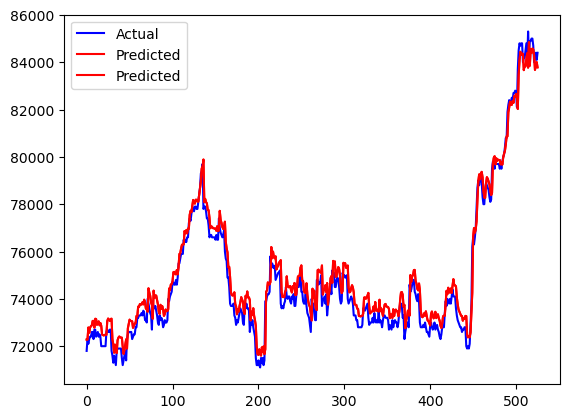

In [48]:
LSTM_model, LSTM_prediction = LSTM_model(x_train, y_train, x_test, sc)
y_test = sc.inverse_transform(y_test)
plt.plot(y_test, color='blue', label='Actual')
plt.plot(LSTM_prediction, color='red', label='Predicted')
plt.legend()
plt.show()